In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist,squareform
from scipy.stats.mstats import zscore
from scipy.stats import norm,percentileofscore

In [64]:
# Random, Random
def rr():
    x1 = np.random.normal(0.5,0.2,50)
    y1 = np.random.normal(0.5,0.2,50)
    A = np.array([x1,y1]).T
    x2 = np.random.normal(0.5,0.2,50)
    y2 = np.random.normal(0.5,0.2,50)
    B = np.array([x2,y2]).T
    return A,B

# Random, Clustered
def rc():
    x1 = np.random.normal(0.5,0.05,50)
    y1 = np.random.normal(0.5,0.05,50)
    A = np.array([x1,y1]).T
    x2 = np.random.normal(0.5,0.2,50)
    y2 = np.random.normal(0.5,0.2,50)
    B = np.array([x2,y2]).T
    return A,B

# Clustered, Clustered, Overlapping
def cco():
    x1 = np.random.normal(0.5,0.05,50)
    y1 = np.random.normal(0.5,0.05,50)
    A = np.array([x1,y1]).T
    x2 = np.random.normal(0.5,0.05,50)
    y2 = np.random.normal(0.5,0.05,50)
    B = np.array([x2,y2]).T
    return A,B

# Clustered, Clustered, Segregated
def ccs():
    x1 = np.random.normal(0.3,0.05,50)
    y1 = np.random.normal(0.3,0.05,50)
    A = np.array([x1,y1]).T
    x2 = np.random.normal(0.7,0.05,50)
    y2 = np.random.normal(0.7,0.05,50)
    B = np.array([x2,y2]).T
    return A,B

# MultiClustered, MultiClustered, Overlapping
def mcmco():
    x1 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.5,0.05,15),np.random.normal(0.7,0.05,15)))
    y1 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.7,0.05,15),np.random.normal(0.3,0.05,15)))
    A = np.array([x1,y1]).T
    x2 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.5,0.05,15),np.random.normal(0.7,0.05,15)))
    y2 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.7,0.05,15),np.random.normal(0.3,0.05,15)))
    B = np.array([x2,y2]).T
    return A,B

# MultiClustered, MultiClustered, Segregated
def mcmcs():
    x1 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.5,0.05,15),np.random.normal(0.7,0.05,15)))
    y1 = np.concatenate((np.random.normal(0.7,0.05,15),np.random.normal(0.3,0.05,15),np.random.normal(0.7,0.05,15)))
    A = np.array([x1,y1]).T
    x2 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.5,0.05,15),np.random.normal(0.7,0.05,15)))
    y2 = np.concatenate((np.random.normal(0.3,0.05,15),np.random.normal(0.7,0.05,15),np.random.normal(0.3,0.05,15)))
    B = np.array([x2,y2]).T
    return A,B

In [65]:
# Plot the Distribution
def dplot(A,B,ax=None):
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.scatter(A[:,0],A[:,1],c="darkred",s=50,lw=1,color='white')
    ax.scatter(B[:,0],B[:,1],c="mediumblue",s=50,lw=1,color='white')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    if not ax:
        plt.show()
    return ax

In [66]:
def Kest(D,T=[]):
    """ Ripley's K-Function Estimator
      D: Masked distance matrix for A->A / B->B point pairs
      T: Distance thresholds """
    N = np.sqrt(D.count()) # Number of non-masked rows
    return np.array([(D<t).sum() for t in T],dtype=np.float64) / (N*(N-1))

def Kstar(D,T=[]):
    """ Ripley's multivariate K-Function Estimator 
      D: Masked distance matrix for A->B pairs
      T: Distance thresholds """
    N = D.count() # Number of non-masked elements
    return np.array([(D<t).sum() for t in T],dtype=np.float64) / N

def permute(MA,N):
    """ Permutes the class A mask for N iterations """
    for i in range(N):
        yield np.random.permutation(MA)

def pstat(Pvec):
    """ Calculates a p-value and z-score for the protein-level
      summary statistic. First row of the vector should contain
      the observation. """
    o = Pvec[0] # observed value
    # Calculate the simulation z-score
    o_z = zscore(Pvec[~np.isnan(Pvec)])[0]
    # Calculate one-sided permutation p-values
    o_p = min(1.,min(2*(1.-percentileofscore(-Pvec,-o,'strict')/100.),2*(1.-percentileofscore(Pvec,o,'strict')/100.)))
    o_pz = norm.sf(abs(o_z))*2 # two-sided simulated p-value
    return o_p,o_z,o_pz

def pstats(Pmat):
    """ Calculates p-values and z-scores for each distance threshold.
      First row of the matrix should contain the observation. """
    o = Pmat[0] # observed values
    # Calculate the simulated z-score
    o_z = zscore(Pmat)[0]
    # Calculate one-sided permutation p-values
    p = []
    for i,z in enumerate(o_z):
        if z>0:
            p.append(min(1.,2*(1.-percentileofscore(Pmat[:,i],o[i],'strict')/100.)))
        else:
            p.append(min(1.,2*(1.-percentileofscore(-Pmat[:,i],-o[i],'strict')/100.)))
    o_p = p
    o_pz = norm.sf(abs(o_z))*2 # two-sided simulated p-value
    # Calculate the confidence envelope
    hce = np.percentile(Pmat,99.5,axis=0)
    lce = np.percentile(Pmat,0.05, axis=0)
    return o_p,o_z,o_pz,hce,lce

def k_plot(T,K,Kz,lce,hce,ax=None):
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,7))
    c = "black"
    ax.scatter(T,K,s=25,color=c)
    ax.fill_between(T,lce,hce,alpha=0.1,
                      edgecolor=c,facecolor=c,
                      interpolate=True,antialiased=True)
#     ax.set_xlabel("Distance Threshold (t)",fontsize=10)
#     ax.set_ylabel("K (Simulation 99% CI)",fontsize=10)
    ax.set_xlim([0,max(T)])
    # Add a vertical line a the most extreme threshold
    dK = np.nanmax(np.abs(Kz),axis=0) # studentized maximum K
    t  = np.nanargmax(np.abs(Kz),axis=0) # t where studentized K is maximized
    # dK = np.nanmax([K-hce,lce-K],axis=0) # directional K-99%
    # t  = np.nanargmax(dK) # t where K is most outside the 99% interval
    T,K = T[t],K[t]
#     ax.axvline(T,color=c,lw=2,ls="dashed",label="Optimal T=%.0f"%T)
    return ax

In [67]:
def Keval(A,B):
    NA = A.shape[0]
    NB = B.shape[0]
    AB = np.concatenate((A,B))                      # AB coordinate matrix
    MA = np.array([1]*NA+[0]*NB).reshape(NA+NB,1)   # A mask
    MB = np.abs(1-MA)                               # B mask
    D  = squareform(pdist(AB))                      # AB distance matrix
    D[np.identity(D.shape[0],dtype=bool)] = np.nan  # Diagonal to NaN
    # Distance thresholds (5 Angstrom minimum, max(D)/3 maximum)
    T  = np.arange(0,1,0.025)

    ## Distance-dependent K derivatives
    KA  = Kest(np.ma.array(D, mask=1-MA*MA.T),T)
    KB  = Kest(np.ma.array(D, mask=1-MB*MB.T),T)
    DAB = KA - KB
    KAB = Kstar(np.ma.array(D,mask=1-MA*MB.T),T)
    KBA = Kstar(np.ma.array(D,mask=1-MB*MA.T),T)

    KAD = KA - KAB
    KBD = KB - KAB
    
    # Random label shuffling permutation test
    PERMUTATIONS=10000
    KAp,KBp,DABp,KABp,KADp,KBDp = [KA],[KB],[DAB],[KAB],[KAD],[KBD] # Initialize with observations
    for i,MA in enumerate(permute(MA,PERMUTATIONS)):
        MB = np.abs(1-MA)
        # Calculate each multivariate K statistic
        KA  = Kest(np.ma.array(D, mask=1-MA*MA.T),T)
        KB  = Kest(np.ma.array(D, mask=1-MB*MB.T),T)
        DAB = KA - KB
        KAB = Kstar(np.ma.array(D,mask=1-MA*MB.T),T)
        KAD = KA - KAB
        KBD = KB - KAB
        # Append permutation iteration to list
        KAp.append(KA)
        KBp.append(KB)
        DABp.append(DAB)
        KABp.append(KAB)
        KADp.append(KAD)
        KBDp.append(KBD)
    # Permutation matrices
    KAp  = np.array(KAp, dtype=np.float64)
    KBp  = np.array(KBp, dtype=np.float64)
    DABp = np.array(DABp,dtype=np.float64)
    KABp = np.array(KABp,dtype=np.float64)
    KADp = np.array(KADp,dtype=np.float64)
    KBDp = np.array(KBDp,dtype=np.float64)
    # Recover the original observations
    KA,KB,DAB,KAB,KAD,KBD = KAp[0],KBp[0],DABp[0],KABp[0],KADp[0],KBDp[0]

    ## Distance-dependent p-values and z-scores
    DAB_p,DAB_z,DAB_zp,DAB_hce,DAB_lce = pstats(DABp)
    KAB_p,KAB_z,KAB_zp,KAB_hce,KAB_lce = pstats(KABp)
    KAD_p,KAD_z,KAD_zp,KAD_hce,KAD_lce = pstats(KADp)
    KBD_p,KBD_z,KBD_zp,KBD_hce,KBD_lce = pstats(KBDp)

    # Determine the optimal T for each statistic
    DAB_t  = T[np.nanargmax(np.abs(DAB_z),axis=0)]
    KAB_t  = T[np.nanargmax(np.abs(KAB_z),axis=0)]
    KAD_t  = T[np.nanargmax(np.abs(KAD_z),axis=0)]
    KBD_t  = T[np.nanargmax(np.abs(KBD_z),axis=0)]

    ## Protein summary statistics
    DABs = np.nanmean(DAB / np.std(DABp,axis=0))
    KABs = np.nanmean(KAB / np.std(KABp,axis=0))
    KADs = np.nanmean(KAD / np.std(KADp,axis=0))
    KBDs = np.nanmean(KBD / np.std(KBDp,axis=0))
    # Calculate protein summary p-value and z-score
    DABsp = np.nanmean(DABp / np.std(DABp,axis=0), axis=1)
    KABsp = np.nanmean(KABp / np.std(KABp,axis=0), axis=1)
    KADsp = np.nanmean(KADp / np.std(KADp,axis=0), axis=1)
    KBDsp = np.nanmean(KBDp / np.std(KBDp,axis=0), axis=1)
    DABs_p,DABs_z,DABs_zp = pstat(DABsp)
    KABs_p,KABs_z,KABs_zp = pstat(KABsp)
    KADs_p,KADs_z,KADs_zp = pstat(KADsp)
    KBDs_p,KBDs_z,KBDs_zp = pstat(KBDsp)
    return T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce

/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in divide
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in divide
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in divide
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in divide
/Users/mikesivley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.

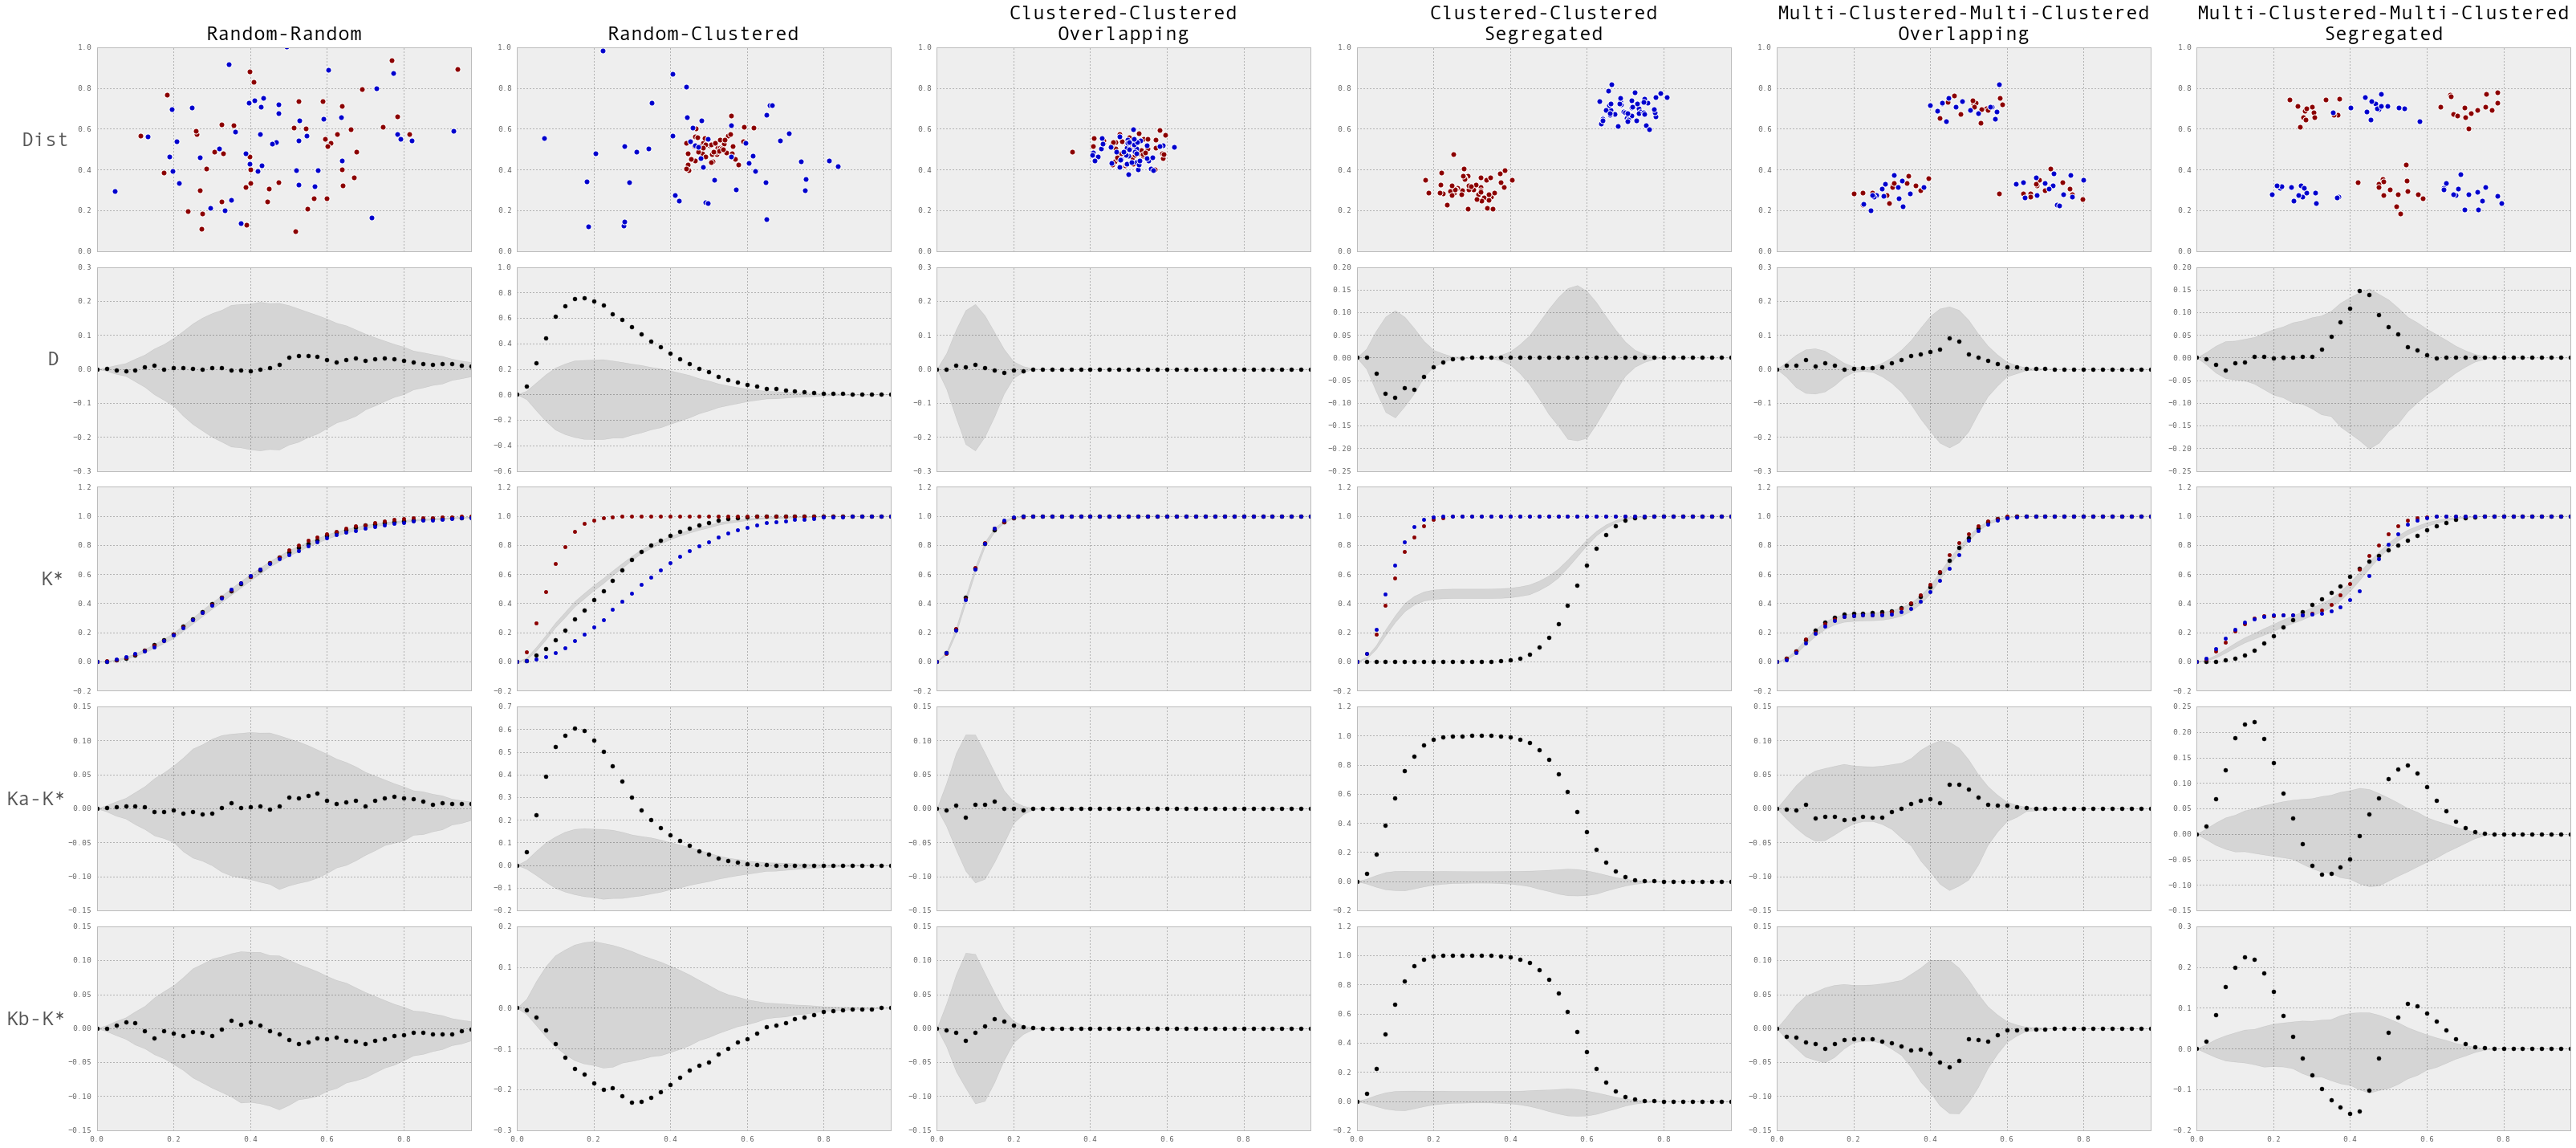

In [68]:
fig,ax = plt.subplots(5,6,figsize=(45,20),sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

# Random,Random
A,B = rr()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][0])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][0])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][0])
ax[2][0].scatter(T,KA,color='darkred',   label="Ka")
ax[2][0].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][0])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][0])

# Random,Clustered
A,B = rc()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][1])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][1])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][1])
ax[2][1].scatter(T,KA,color='darkred',   label="Ka")
ax[2][1].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][1])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][1])

# Clustered,Clustered,Overlapping
A,B = cco()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][2])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][2])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][2])
ax[2][2].scatter(T,KA,color='darkred',   label="Ka")
ax[2][2].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][2])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][2])

# Clustered,Clustered,Segregated
A,B = ccs()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][3])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][3])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][3])
ax[2][3].scatter(T,KA,color='darkred',   label="Ka")
ax[2][3].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][3])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][3])

# MultiClustered,MultiClustered,Overlapping
A,B = mcmco()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][4])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][4])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][4])
ax[2][4].scatter(T,KA,color='darkred',   label="Ka")
ax[2][4].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][4])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][4])

# MultiClustered,MultiClustered,Segregated
A,B = mcmcs()
T,KA,KB,DAB,DAB_z,DAB_lce,DAB_hce,KAB,KAB_z,KAB_lce,KAB_hce,KAD,KAD_z,KAD_lce,KAD_hce,KBD,KBD_z,KBD_lce,KBD_hce = Keval(A,B)
dplot(A,B,ax[0][5])
k_plot(T,DAB,DAB_z,DAB_lce,DAB_hce,ax[1][5])
k_plot(T,KAB,KAB_z,KAB_lce,KAB_hce,ax[2][5])
ax[2][5].scatter(T,KA,color='darkred',   label="Ka")
ax[2][5].scatter(T,KB,color='mediumblue',label="Kb")
k_plot(T,KAD,KAD_z,KAD_lce,KAD_hce,ax[3][5])
k_plot(T,KBD,KBD_z,KBD_lce,KBD_hce,ax[4][5])

# Set column labels
ax[0][0].set_title("Random-Random",fontsize=25,y=1.02)
ax[0][1].set_title("Random-Clustered",fontsize=25,y=1.02)
ax[0][2].set_title("Clustered-Clustered\nOverlapping",fontsize=25,y=1.02)
ax[0][3].set_title("Clustered-Clustered\nSegregated",fontsize=25,y=1.02)
ax[0][4].set_title("Multi-Clustered-Multi-Clustered\nOverlapping",fontsize=25,y=1.02)
ax[0][5].set_title("Multi-Clustered-Multi-Clustered\nSegregated",fontsize=25,y=1.02)

# Set row labels
ax[0][0].set_ylabel("Dist",rotation='horizontal',fontsize=25,labelpad=40)
ax[1][0].set_ylabel("D",rotation='horizontal',fontsize=25,labelpad=25)
ax[2][0].set_ylabel("K*",rotation='horizontal',fontsize=25,labelpad=25)
ax[3][0].set_ylabel("Ka-K*",rotation='horizontal',fontsize=25,labelpad=40)
ax[4][0].set_ylabel("Kb-K*",rotation='horizontal',fontsize=25,labelpad=40)

plt.tight_layout()
plt.show()